src: https://github.com/suicao/PhoBert-Sentiment-Classification

In [1]:
!nvidia-smi

Mon Dec  7 04:44:42 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls "/content/gdrive/MyDrive/Uni/DataMining/tq"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
checkpoints	phobert_kfold.ipynb		 preprocessed_lowcase.csv
phobert2.ipynb	preprocessed_case_sensitive.csv  segmented.csv
phobert.ipynb	preprocessed_for_tfidf_svm.csv	 topic_detection_train.v1.0.csv


In [3]:
!pip install -q vncorenlp
!pip install -q transformers

     |████████████████████████████████| 2.7MB 20.7MB/s 
     |████████████████████████████████| 1.4MB 11.7MB/s 
     |████████████████████████████████| 890kB 49.7MB/s 
     |████████████████████████████████| 2.9MB 49.1MB/s 


# Import modules

In [2]:
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from tqdm import tqdm
tqdm.pandas()
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

from transformers import AutoModel, AutoTokenizer, AutoConfig
from transformers import *
from transformers.modeling_utils import * 
#from fairseq.data.encoders.fastbpe import fastBPE
#from fairseq.data import Dictionary
from vncorenlp import VnCoreNLP

#utils
def seed_everything(SEED):
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def adjust_learning_rate(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Data

In [3]:
''' This is executed once, for producing the segmented .csv file
# Get word segmentator
!mkdir -p vncorenlp/models/wordsegmenter
!wget -q https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
!wget -q https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
!wget -q https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/wordsegmenter.rdr
!mv VnCoreNLP-1.1.1.jar vncorenlp/ 
!mv vi-vocab vncorenlp/models/wordsegmenter/
!mv wordsegmenter.rdr vncorenlp/models/wordsegmenter/

rdrsegmenter = VnCoreNLP('./vncorenlp/VnCoreNLP-1.1.1.jar', annotators="wseg", max_heap_size='-Xmx500m') 

train_df = pd.read_csv('/content/gdrive/MyDrive/Uni/DataMining/tq/topic_detection_train.v1.0.csv', sep='\t', header=None)
train_df.iloc[:,1] = train_df.iloc[:,1].progress_apply(lambda x: ' '.join([' '.join(sent) for sent in rdrsegmenter.tokenize(x)]))

train_df.to_csv('./segmented_text_train.csv', sep='\t')
!cp './segmented_text_train.csv' '/content/gdrive/MyDrive/Uni/DataMining/tq/segmented_text_train.csv'
'''

' This is executed once, for producing the segmented .csv file\n# Get word segmentator\n!mkdir -p vncorenlp/models/wordsegmenter\n!wget -q https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar\n!wget -q https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab\n!wget -q https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/wordsegmenter.rdr\n!mv VnCoreNLP-1.1.1.jar vncorenlp/ \n!mv vi-vocab vncorenlp/models/wordsegmenter/\n!mv wordsegmenter.rdr vncorenlp/models/wordsegmenter/\n\nrdrsegmenter = VnCoreNLP(\'./vncorenlp/VnCoreNLP-1.1.1.jar\', annotators="wseg", max_heap_size=\'-Xmx500m\') \n\ntrain_df = pd.read_csv(\'/content/gdrive/MyDrive/Uni/DataMining/tq/topic_detection_train.v1.0.csv\', sep=\'\t\', header=None)\ntrain_df.iloc[:,1] = train_df.iloc[:,1].progress_apply(lambda x: \' \'.join([\' \'.join(sent) for sent in rdrsegmenter.tokenize(x)]))\n\ntrain_df.to_csv(\'./segmented_text_train.csv\', sep

In [4]:
# Get tokenizer
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)

# Load training data
train_df = pd.read_csv('/content/gdrive/MyDrive/Uni/DataMining/tq/preprocessed_case_sensitive.csv', sep='\t', header=None)

# tokenize
X = train_df.iloc[:,1].apply(lambda x: tokenizer.encode(x, max_length=256, padding='max_length', truncation=True) )

# label encoding
label_encoder = LabelEncoder()
y = train_df.iloc[:,0]
y = label_encoder.fit_transform(y)

cls_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
cls_weights = torch.tensor(cls_weights).float().cuda()
cls_weights = None

Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


In [5]:
'''
seed_everything(42)
splits = list(StratifiedKFold(n_splits=5, shuffle=True, random_state=42).split(X, y))

#for fold, (train_idx, val_idx) in enumerate(splits):
train_idx, val_idx = splits[0]

train_dataset = torch.utils.data.TensorDataset(torch.tensor(X[train_idx].tolist(),dtype=torch.long), torch.tensor(y[train_idx],dtype=torch.long))
valid_dataset = torch.utils.data.TensorDataset(torch.tensor(X[val_idx].tolist(),dtype=torch.long), torch.tensor(y[val_idx],dtype=torch.long))

train_loader32 = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader32 = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=False)
'''

'\nseed_everything(42)\nsplits = list(StratifiedKFold(n_splits=5, shuffle=True, random_state=42).split(X, y))\n\n#for fold, (train_idx, val_idx) in enumerate(splits):\ntrain_idx, val_idx = splits[0]\n\ntrain_dataset = torch.utils.data.TensorDataset(torch.tensor(X[train_idx].tolist(),dtype=torch.long), torch.tensor(y[train_idx],dtype=torch.long))\nvalid_dataset = torch.utils.data.TensorDataset(torch.tensor(X[val_idx].tolist(),dtype=torch.long), torch.tensor(y[val_idx],dtype=torch.long))\n\ntrain_loader32 = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)\nvalid_loader32 = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=False)\n'

In [6]:
seed_everything(42)
splits = list(StratifiedKFold(n_splits=5, shuffle=True, random_state=42).split(X, y))

#for fold, (train_idx, val_idx) in enumerate(splits):
train_idx, val_idx = splits[0]

# special train set #replace cls 20 with 9
special_train_labels = np.where(y[train_idx]==20, 9, y[train_idx])
train_dataset = torch.utils.data.TensorDataset(torch.tensor(X[train_idx].tolist(),dtype=torch.long), torch.tensor(special_train_labels,dtype=torch.long))
valid_dataset = torch.utils.data.TensorDataset(torch.tensor(X[val_idx].tolist(),dtype=torch.long), torch.tensor(y[val_idx],dtype=torch.long))

train_loader32 = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader32 = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=False)

# Model

In [7]:
class PhoBertTextClassifier(torch.nn.Module):
    def __init__(self, num_labels):
        super(PhoBertTextClassifier, self).__init__()
        self.num_labels = num_labels
        #self.roberta = RobertaModel(config)
        self.phobert = AutoModel.from_pretrained("vinai/phobert-base", output_hidden_states=True)
        self.clf = torch.nn.Sequential(
            torch.nn.Linear(2*768, 256),
            torch.nn.Dropout(0.1),
            torch.nn.Tanh(),
            torch.nn.Linear(256, self.num_labels)
        )

    def forward(self, input_ids, attention_mask=None, token_type_ids=None, position_ids=None, head_mask=None, start_positions=None, end_positions=None):
        features = self.phobert(input_ids, attention_mask=attention_mask, position_ids=position_ids, head_mask=head_mask)
        features = torch.cat((features[2][-1][:,0, ...],features[2][-2][:,0, ...]),-1)
        logits = self.clf(features)
        return logits

# Train kfold

In [8]:
def train_one_epoch(model, train_loader, optimizer):
    model.train()
    sum_loss = 0.
    avg_loss = 0.
    pbar = tqdm(enumerate(train_loader), total=len(train_loader), position=0, leave=True)
    for i, (x_batch, y_batch) in pbar:    
        y_pred = model(x_batch.cuda(), attention_mask=(x_batch!=1).cuda())
        loss = F.cross_entropy(y_pred, y_batch.cuda(), weight=cls_weights)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        sum_loss += loss.item()
        avg_loss = sum_loss/(i+1)
        if i%10 == 0: pbar.set_description(f"loss: {avg_loss:.2f}")
    return avg_loss

@torch.no_grad()
def eval(model, valid_loader):
    model.eval()
    sum_loss = 0.
    pred = []
    y = []
    pbar = tqdm(enumerate(valid_loader), total=len(valid_loader), position=0, leave=True, desc='eval epoch')
    for i, (x_batch, y_batch) in pbar:
        y_pred = model(x_batch.cuda(), attention_mask=(x_batch!=1).cuda())
        loss = F.cross_entropy(y_pred, y_batch.cuda(), weight=cls_weights)
        sum_loss += loss.item()
        y_pred = y_pred.squeeze().detach().argmax(dim=1).cpu().numpy()
        pred.extend(y_pred.tolist())
        y.extend(y_batch.tolist())
    return {
        'loss': sum_loss/len(valid_loader), 
        'pred': pred,
        'gt': y,
        'accuracy': round(accuracy_score(y, pred),3)
    }

In [9]:
phobert_clfs = []
eval_results = []

seed_everything(42)
splits = list(StratifiedKFold(n_splits=5, shuffle=True, random_state=42).split(X, y))

for fold, (train_idx, val_idx) in enumerate(splits):
    print(f"==========fold:{fold+1}===========")
    # special train set #replace cls 20 with 9
    special_train_labels = np.where(y[train_idx]==20, 9, y[train_idx])
    train_dataset = torch.utils.data.TensorDataset(torch.tensor(X[train_idx].tolist(),dtype=torch.long), torch.tensor(special_train_labels,dtype=torch.long))
    valid_dataset = torch.utils.data.TensorDataset(torch.tensor(X[val_idx].tolist(),dtype=torch.long), torch.tensor(y[val_idx],dtype=torch.long))
    train_loader32 = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
    valid_loader32 = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=False)

    phobert_clf = PhoBertTextClassifier(num_labels=23)
    phobert_clf.cuda()

    # Creating optimizer and lr schedulers
    param_optimizer = list(phobert_clf.named_parameters())
    no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=1e-3, correct_bias=False)  # To reproduce BertAdam specific behavior set correct_bias=False

    #train for 3 epoch each fold
    phobert_clf.phobert.requires_grad_(False)
    train_loss = train_one_epoch(phobert_clf, train_loader32, optimizer)
    eval_result = eval(phobert_clf, valid_loader32); print('>> accuracy:', eval_result['accuracy'])

    phobert_clf.phobert.requires_grad_(True)
    adjust_learning_rate(optimizer, 3e-5)
    train_loss = train_one_epoch(phobert_clf, train_loader32, optimizer)
    eval_result = eval(phobert_clf, valid_loader32); print('>> accuracy:', eval_result['accuracy'])

    adjust_learning_rate(optimizer, 1e-5)
    train_loss = train_one_epoch(phobert_clf, train_loader32, optimizer)
    eval_result = eval(phobert_clf, valid_loader32); print('>> accuracy:', eval_result['accuracy'])
    phobert_clfs.append(phobert_clf)
    eval_results.append(eval_result)
    torch.save(model_bert.state_dict(), os.path.join(args.ckpt_path, f"model_{fold}.bin"))

==========fold:1===========


  0%|          | 0/400 [00:00<?, ?it/s]

>> accuracy: 0.857


  0%|          | 0/400 [00:00<?, ?it/s]

>> accuracy: 0.886


eval epoch: 100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


>> accuracy: 0.895
==========fold:2===========


  0%|          | 0/400 [00:00<?, ?it/s]

>> accuracy: 0.861


  0%|          | 0/400 [00:00<?, ?it/s]

>> accuracy: 0.891


eval epoch: 100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


>> accuracy: 0.896
==========fold:3===========


  0%|          | 0/400 [00:00<?, ?it/s]

>> accuracy: 0.858


  0%|          | 0/400 [00:00<?, ?it/s]

>> accuracy: 0.867


eval epoch: 100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


>> accuracy: 0.889
==========fold:4===========


  0%|          | 0/400 [00:00<?, ?it/s]

>> accuracy: 0.86


loss: 0.28:   0%|          | 1/400 [00:01<09:12,  1.38s/it]

RuntimeError: ignored

In [21]:
for fold, model in enumerate(phobert_clfs):
    torch.save(model.state_dict(), f"/content/gdrive/MyDrive/Uni/DataMining/tq/checkpoints/model_{fold}.bin")

In [23]:
del phobert_clfs
torch.cuda.empty_cache()

**Continue with fold 4 and 5**

In [24]:
phobert_clfs = []
eval_results = []

#seed_everything(42)
#splits = list(StratifiedKFold(n_splits=5, shuffle=True, random_state=42).split(X, y))

for fold, (train_idx, val_idx) in enumerate(splits):
    if fold+1 < 4: continue
    print(f"==========fold:{fold+1}===========")
    # special train set #replace cls 20 with 9
    special_train_labels = np.where(y[train_idx]==20, 9, y[train_idx])
    train_dataset = torch.utils.data.TensorDataset(torch.tensor(X[train_idx].tolist(),dtype=torch.long), torch.tensor(special_train_labels,dtype=torch.long))
    valid_dataset = torch.utils.data.TensorDataset(torch.tensor(X[val_idx].tolist(),dtype=torch.long), torch.tensor(y[val_idx],dtype=torch.long))
    train_loader32 = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
    valid_loader32 = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=False)

    phobert_clf = PhoBertTextClassifier(num_labels=23)
    phobert_clf.cuda()

    # Creating optimizer and lr schedulers
    param_optimizer = list(phobert_clf.named_parameters())
    no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=1e-3, correct_bias=False)  # To reproduce BertAdam specific behavior set correct_bias=False

    #train for 3 epoch each fold
    phobert_clf.phobert.requires_grad_(False)
    train_loss = train_one_epoch(phobert_clf, train_loader32, optimizer)
    eval_result = eval(phobert_clf, valid_loader32); print('>> accuracy:', eval_result['accuracy'])

    phobert_clf.phobert.requires_grad_(True)
    adjust_learning_rate(optimizer, 3e-5)
    train_loss = train_one_epoch(phobert_clf, train_loader32, optimizer)
    eval_result = eval(phobert_clf, valid_loader32); print('>> accuracy:', eval_result['accuracy'])

    adjust_learning_rate(optimizer, 1e-5)
    train_loss = train_one_epoch(phobert_clf, train_loader32, optimizer)
    eval_result = eval(phobert_clf, valid_loader32); print('>> accuracy:', eval_result['accuracy'])
    phobert_clfs.append(phobert_clf)
    eval_results.append(eval_result)
    torch.save(model_bert.state_dict(), os.path.join(args.ckpt_path, f"model_{fold}.bin"))  # oops @@

==========fold:4===========


  0%|          | 0/400 [00:00<?, ?it/s]

>> accuracy: 0.853


  0%|          | 0/400 [00:00<?, ?it/s]

>> accuracy: 0.89


eval epoch: 100%|██████████| 100/100 [00:48<00:00,  2.08it/s]

>> accuracy: 0.89


NameError: ignored

In [25]:
torch.save(phobert_clfs[0].state_dict(), f"/content/gdrive/MyDrive/Uni/DataMining/tq/checkpoints/model_3.bin")

In [10]:
del phobert_clf
del optimizer
torch.cuda.empty_cache()

In [11]:
phobert_clfs = []
eval_results = []
for fold, (train_idx, val_idx) in enumerate(splits):
    if fold+1 < 5: continue
    print(f"==========fold:{fold+1}===========")
    # special train set #replace cls 20 with 9
    special_train_labels = np.where(y[train_idx]==20, 9, y[train_idx])
    train_dataset = torch.utils.data.TensorDataset(torch.tensor(X[train_idx].tolist(),dtype=torch.long), torch.tensor(special_train_labels,dtype=torch.long))
    valid_dataset = torch.utils.data.TensorDataset(torch.tensor(X[val_idx].tolist(),dtype=torch.long), torch.tensor(y[val_idx],dtype=torch.long))
    train_loader32 = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
    valid_loader32 = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=False)

    phobert_clf = PhoBertTextClassifier(num_labels=23)
    phobert_clf.cuda()

    # Creating optimizer and lr schedulers
    param_optimizer = list(phobert_clf.named_parameters())
    no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=1e-3, correct_bias=False)  # To reproduce BertAdam specific behavior set correct_bias=False

    #train for 3 epoch each fold
    phobert_clf.phobert.requires_grad_(False)
    train_loss = train_one_epoch(phobert_clf, train_loader32, optimizer)
    eval_result = eval(phobert_clf, valid_loader32); print('>> accuracy:', eval_result['accuracy'])

    phobert_clf.phobert.requires_grad_(True)
    adjust_learning_rate(optimizer, 2e-5)
    train_loss = train_one_epoch(phobert_clf, train_loader32, optimizer)
    eval_result = eval(phobert_clf, valid_loader32); print('>> accuracy:', eval_result['accuracy'])

    adjust_learning_rate(optimizer, 1e-5)
    train_loss = train_one_epoch(phobert_clf, train_loader32, optimizer)
    eval_result = eval(phobert_clf, valid_loader32); print('>> accuracy:', eval_result['accuracy'])
    phobert_clfs.append(phobert_clf)
    eval_results.append(eval_result)

==========fold:5===========


  0%|          | 0/400 [00:00<?, ?it/s]

>> accuracy: 0.849


  0%|          | 0/400 [00:00<?, ?it/s]

>> accuracy: 0.882


eval epoch: 100%|██████████| 100/100 [00:48<00:00,  2.08it/s]

>> accuracy: 0.889


In [12]:
torch.save(phobert_clfs[0].state_dict(), f"/content/gdrive/MyDrive/Uni/DataMining/tq/checkpoints/model_4.bin")

# Confusion matrix

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(confusion_matrix(eval_result['gt'], eval_result['pred']), cmap="YlGnBu", annot=True, fmt="d")
plt.show()

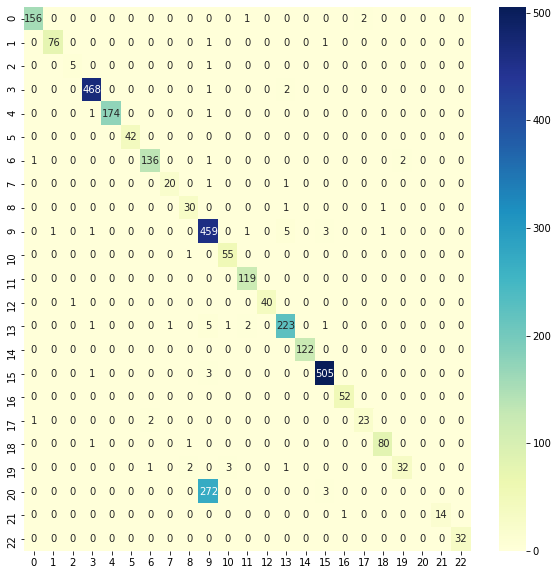

In [22]:
plt.figure(figsize=(10,10))
sns.heatmap(confusion_matrix(eval_results[0]['gt'], eval_results[0]['pred']), cmap="YlGnBu", annot=True, fmt="d")
plt.show()

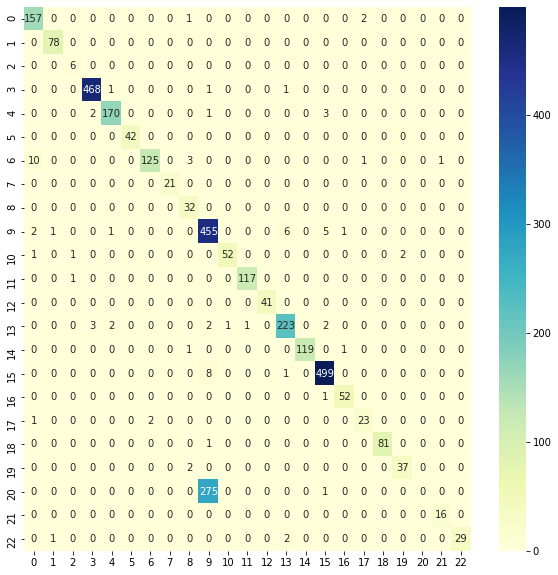

In [13]:
plt.figure(figsize=(10,10))
sns.heatmap(confusion_matrix(eval_results[0]['gt'], eval_results[0]['pred']), cmap="YlGnBu", annot=True, fmt="d")
plt.show()

In [ ]:
@torch.no_grad()
def eval2(model, valid_loader):
    model.eval()
    pred = []
    y = []
    pbar = tqdm(enumerate(valid_loader), total=len(valid_loader), position=0, leave=True, desc='eval epoch')
    for i, (x_batch, y_batch) in pbar:
        y_pred = model(x_batch.cuda(), attention_mask=(x_batch!=1).cuda())
        y_pred = y_pred.squeeze().detach().argmax(dim=1).cpu().numpy()
        y_pred = np.where(y_pred==20, 9, y_pred)  #replace prediction 20 with 9
        pred.extend(y_pred.tolist())
        y.extend(y_batch.tolist())
    return {
        'pred': pred,
        'gt': y,
        'accuracy': round(accuracy_score(y, pred),3)
    }
eval_result = eval2(phobert_clf, valid_loader32); print('>> accuracy:', eval_result['accuracy'])